# Modern Portfolio Theory

## Model

### Assumptions

* Investors are risk averse, meaning that given two portfolios that offer the same expected return, investors will prefer the less risky one. 

* An investor will take on increased risk only if compensated by higher expected returns. 

* Conversely, an investor who wants higher expected returns must accept more risk. 

* The exact trade-off will be the same for all investors, but different investors will evaluate the trade-off differently based on individual risk aversion characteristics. 

* The implication is that a rational investor will not invest in a portfolio if a second portfolio exists with a more favorable risk-expected return profile – i.e., if for that level of risk an alternative portfolio exists that has better expected returns.

* There are 252 trading days in a calendar year on average.

### Modules

First we import the modules needed for making the workbook work

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import scipy.stats as scs
import scipy.optimize as sco
import statsmodels.api as sm
import scipy.interpolate as sci
plt.style.use('ggplot')
np.random.seed(1479)

### Definitions

In [2]:
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf

In [3]:
def yprices(name, start, end):
    '''    
        Arguments: 
            name(string)    : input the ticker for the desired stock
            start(datetime) : Setting a starting date
            end(datetime)   : Setting a ending date 
         Returns:
            The function returns a Pandas DataFrame webscraped from yahoo finance containing the Date, High, Low, Close, Adj Close and Volume for the inquired stock 
            More information can be found at https://github.com/ranaroussi/fix-yahoo-finance
    '''
    yf.pdr_override() # Command to override the pandas search function
    return pdr.get_data_yahoo(name, start, end)

In [4]:
def statistics(weights):
 weights = np.array(weights)
 pret = np.sum(rets.mean() * weights) * 252 # Portfolio annulized return
 pvol = np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights))) # Portfolio annulized standard deviation
 return np.array([pret, pvol, pret / pvol]) # Portfolio annulized return, Portfolio annulized standard deviation, Portfolio Sharpe ratio

In [5]:
def min_func_sharpe(weights):
     return -statistics(weights)[2] # the negative sharpe ratio

In [6]:
def min_func_variance(weights):
     return statistics(weights)[1] ** 2 # portfolio variance

In [7]:
def min_func_port(weights):
     return statistics(weights)[1] #portfolio function

### Data collecting

In [8]:
symbols = ['AAPL', 'MSFT', 'JPM', 'DB', 'GLD']
noa = len(symbols)

In [9]:
start = datetime.datetime(2010, 1, 28)

In [10]:
end = datetime.datetime(2018, 10, 3)

Doing a webscrape of the yahoo price website for the quoted tickers, and lastly looking at the head and tail of the dataframe to ensure that we have the data needed for making the analysis and ensuring that we can optimize the porfolio

In [12]:
data = pd.DataFrame()
for sym in symbols:
 data[sym] = yprices(sym, start, end)['Adj Close']
data.columns = symbols
#loop that creates a dataframe
data.iloc[np.r_[0:4, -4:0]]

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


,AAPL,MSFT,JPM,DB,GLD
Date,,,,,
2010-01-27,19.802147,23.597769,31.211039,51.200840,106.529999
2010-01-28,18.983883,23.192135,31.330078,50.284924,106.480003
2010-01-29,18.295170,22.412704,30.901550,49.859688,105.959999
2010-02-01,18.549507,22.595629,31.449110,51.887768,108.349998
2018-09-27,223.210526,113.433426,111.950874,11.810000,112.050003
2018-09-28,223.994431,113.393768,110.308563,11.360000,112.760002
2018-10-01,225.502670,114.623184,110.953758,11.250000,112.570000
2018-10-02,227.507050,114.167114,111.413216,11.130000,113.870003


### Data visualization and Analysis

We calculate the log daily returns (percent change compared to the day before). By using daily returns instead of actual prices, we can see the stocks’ volatility.

In [13]:
rets = np.log(data / data.shift(1))
#new column for returns based on position above
#this uses log returns
rets.head(2)
#checking log returns

,AAPL,MSFT,JPM,DB,GLD
Date,,,,,
2010-01-27,NaN,NaN,NaN,NaN,NaN
2010-01-28,-0.0422,-0.017339,0.003807,-0.018051,-0.000469


Text(0, 0.5, 'daily returns')

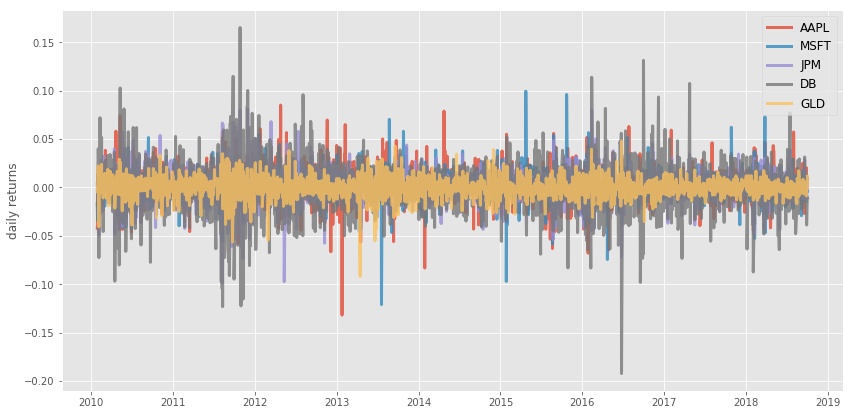

In [14]:
plt.figure(figsize=(14, 7))
for c in rets.columns.values:
    plt.plot(rets.index, rets[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

Deutsche Bank has two distinctive positive spikes and a couple of negative ones. Deutsche Bank has one highest positive spike. And Apple also has some spikes stand out from the plot. From the above plot, we can roughly see that Deutsche Bank looks like a quite risky stock, and gold seems to be the most stable one among them.

### Means, covariances and other measures

The annualized return of the different stocks

In [15]:
rets.mean() * 252
#simple arithmetic mean

AAPL    0.281441
MSFT    0.181739
JPM     0.146690
DB     -0.175929
GLD     0.007681
dtype: float64

The annual covariance matrix

In [16]:
eweights = np.array(noa * [1. / noa,])
eweights

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [17]:
rets.cov()*252

,AAPL,MSFT,JPM,DB,GLD
AAPL,0.063694,0.023250,0.022396,0.031590,0.001327
MSFT,0.023250,0.050130,0.026977,0.036669,-0.000468
JPM,0.022396,0.026977,0.065390,0.067839,-0.003084
DB,0.031590,0.036669,0.067839,0.160622,0.000175
GLD,0.001327,-0.000468,-0.003084,0.000175,0.025668


#### Portfolio weights

In [18]:
weights = np.random.random(noa)
#new numpy array of 4 random number that add up to 1
weights /= np.sum(weights)
#second line assures weight are equal to 1
weights

array([0.05282443, 0.3201937 , 0.27244896, 0.01352046, 0.34101245])

In [19]:
weights.sum()

1.0

Expected return of i'th portfolio $\mathbb{E} R_{i}=w_{i, j}^{T} \times \mathbb{E} R_{j}$

In [20]:
np.sum(rets.mean() * weights) * 252

0.11326471685712543

Volatility of i'th portfolio $\sigma_{i}^{2}=w_{i, j}^{T} \times \operatorname{cov}\left(R_{j}\right) \times w_{i, j}$

In [21]:
np.dot(weights.T, np.dot(rets.cov() * 252, weights))

0.01955983364085654

Standard Deviations of the i'th portfolio $\sqrt{\sigma_{i}^{2}=w_{i, j}^{T} \times \operatorname{cov}\left(R_{j}\right) \times w_{i, j}}$

In [22]:
np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

0.1398564751481194

### Monte Carlo simulation

In [23]:
prets = []
pvols = []
#prets and vols are np.arrays
for p in range (30000):
 #loop underlines number of iterations for a random waiting
 weights = np.random.random(noa)
 weights /= np.sum(weights)
 #this makes it equal to 1
 prets.append(np.sum(rets.mean() * weights) * 252)
 #i get a value for each loop
 pvols.append(np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights))))
  #covariance value for each loop

prets = np.array(prets)
pvols = np.array(pvols)
#turns prets and pvols from lists into numpy arrays
print("Simulation done")

Simulation done


#### Visualization

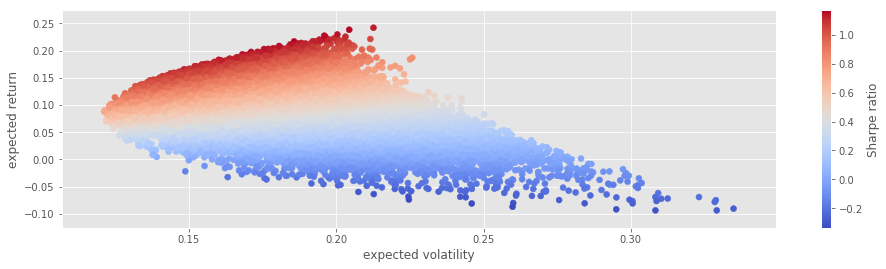

In [24]:

plt.figure(figsize=(16, 4))
plt.scatter(pvols, prets, c = prets / pvols, marker='o', cmap='coolwarm')
# c is a calculated column of a sharpe ratio minus a risk free rate
# x-axis, y-axis, marker allows me to change the point style
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

Now we build a function that, for a given vector of portfolio weights $w_i$, it
returns the portfolio’s expected return, volatility, and the Sharpe ratio
(as a vector).

Where the sharpe ratio is defined as the average return earned in excess of the risk-free rate per unit of volatility or total risk


$S_a  =\frac{R_{p}-R_{f}}{\sigma_{p}}$

where

$\begin{aligned} R_{p} &=\textit { Return of portfolio } \\ R_{f} &=\textit { Risk-free rate } \\ \sigma_{p} &=\textit { Standard deviation of the portfolio's excess return } \end{aligned}$

In [25]:
def statistics(weights):
 weights = np.array(weights)
 pret = np.sum(rets.mean() * weights) * 252 # annualized portfolio return
 pvol = np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights))) # annualized portfolio variance
 return np.array([pret, pvol, pret / pvol]) # a tuble of annualized portfolio return, annualized portfolio variance and Sharpe Ratio of the portfolio

The output from the statistics function creates an tuble containing $\mathbb{E} R_{i},\sigma_{i}^{2},\frac{R_{p}-R_{f}}{\sigma_{p}}$  

Importing the optimization module from Scipy

In [26]:
import scipy.optimize as sco

Define a function for the negative Sharpe ratio
(we want to maximise it)

In [27]:
def min_func_sharpe(weights):
 return -statistics(weights)[2]

This function returns the negative sharpe ratio

Set up the constraint that portfolio weights add up to one $\sum^{n}_{i=1}w_i=1$

In [28]:
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
#this is a dictionary with two objects, that constrains the optimization

Set up boundaries for the portfolio weights (between 0 and 1)

In [29]:
bnds = tuple((0, 1) for x in range(noa))

## Maximum Sharpe ratio portfolio

In [30]:
%%time
opts = sco.minimize(min_func_sharpe, noa * [1. / noa,], method='SLSQP', bounds=bnds, constraints=cons)

Wall time: 73.5 ms


In [31]:
opts

     fun: -1.1820334564932349
     jac: array([ 7.44163990e-05, -1.40830874e-04, -1.16348267e-04,  1.86719047e+00,
        4.55528498e-05])
 message: 'Optimization terminated successfully.'
    nfev: 49
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([6.23941367e-01, 3.03080649e-01, 4.35953298e-02, 9.10729825e-17,
       2.93826543e-02])

Printing portfolio weights for the optimal sharpe portfolio allocation

In [32]:
opts['x'].round(4)
#creates nparray based on key 'x' from the optimization, and rounds to 3 digit

array([0.6239, 0.3031, 0.0436, 0.    , 0.0294])

In [33]:
round(opts['x'].sum(),2)

1.0

Printing the expected return, variance and standard deviation from the assets in the portfolio based on their individual weights

In [34]:
statistics(opts['x']).round(3)

array([0.237, 0.201, 1.182])

Maximum Sharpe ratio portfolio properties

## Minimum variance portfolio

In [35]:
%%time
optv = sco.minimize(min_func_variance, noa * [1. / noa,], method='SLSQP', bounds=bnds,
constraints=cons)

Wall time: 154 ms


In [36]:
optv

     fun: 0.014553856738640594
     jac: array([0.02871223, 0.02924849, 0.028754  , 0.03847875, 0.02922089])
 message: 'Optimization terminated successfully.'
    nfev: 64
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([1.00399850e-01, 1.74983413e-01, 1.42768045e-01, 1.57209315e-18,
       5.81848692e-01])

In [37]:
optv['x'].round(3)

array([0.1  , 0.175, 0.143, 0.   , 0.582])

In [38]:
statistics(optv['x']).round(3)

array([0.085, 0.121, 0.708])

### EFFICIENT FRONTIER

Using Scipy to minimize the sharpe function

$\min_{w_{i}} w_{i}^{T} \Sigma w_{i}$

s.t

$w_{i}^{T} R=R_{\text { target }}$


where portfolio variances is defined as

 $w^TAw$= $\begin{bmatrix}w_1 \cdots w_n\end{bmatrix} \cdot \begin{bmatrix}
\sigma_{n1}^{2}& \cdots & \sigma_{1m}^{2}\\
\vdots     & \ddots & \vdots \\
\sigma_{n1}^{2}& \cdots & \sigma_{nm}^{2}\\
\end{bmatrix}
\cdot
\begin{bmatrix} 
w_1  \\
\vdots  \\
w_n  \\
\end{bmatrix}$ 



* We solve this problem for many levels of the target return.
* Each time we do, we get another point on the efficient frontier.
* We need to specify the constraint in a loop, as the target return
is always changing.

In [39]:
cons = ({'type': 'eq', 'fun': lambda x: statistics(x)[0] - tret},
{'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0, 1) for x in weights)
#normal bounds for optimization

Define a range for target returns.

In [40]:
%%time
trets = np.linspace(0.0, 0.25, 100)
#100 iterations, and the bounds
tvols = []
for tret in trets:
 cons = ({'type': 'eq', 'fun': lambda x: statistics(x)[0] - tret}, {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
 res = sco.minimize(min_func_port, noa * [1. / noa,], method='SLSQP', bounds=bnds, constraints=cons)
 tvols.append(res['fun'])
tvols = np.array(tvols)

Wall time: 9.43 s


#### Visualization

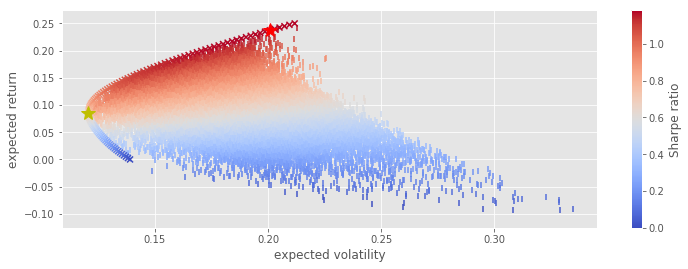

In [41]:
plt.figure(figsize=(12, 4))
plt.scatter(pvols, prets,
 c=prets / pvols, marker='|', cmap ='coolwarm')
 # random portfolio composition
plt.scatter(tvols, trets,
 c=trets / tvols, marker='x', cmap='coolwarm')
 # efficient frontier
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],
 'r*', markersize=15.0)
 # portfolio with highest Sharpe ratio
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0],
 'y*', markersize=15.0)
 # minimum variance portfolio
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

# CAPITAL MARKET LINE

In [42]:
import scipy.interpolate as sci

The trick is to remember that the return vector is sorted in ascending
order.
Portfolios with returns above the minimum variance portfolio are
non-dominated!

In [43]:
ind = np.argmin(tvols)
evols = tvols[ind:]
erets = trets[ind:]

In [44]:
tck = sci.splrep(evols, erets)

In [45]:
def f(x):
#Efficient frontier function (splines approximation)
 return sci.splev(x, tck, der=0)
def df(x):
#First derivative of efficient frontier function
 return sci.splev(x, tck, der=1)

$\begin{aligned} t(x) &=a+b \cdot x \\ t(0) &=r_{f} \\ t(x) &=f(x) \\ t(x) &=f(x) & \Leftrightarrow \quad b \end{aligned}=f(x)$

In [46]:
def equations(p, rf=0.03):
 eq1 = rf - p[0]
 eq2 = rf + p[1] * p[2] - f(p[2])
 eq3 = p[1] - df(p[2])
 return eq1, eq2, eq3

In [47]:
opt = sco.fsolve(equations, [0.01, 0.5, 0.15])

In [48]:
opt

array([0.03      , 1.03865225, 0.21223394])

In [49]:
np.round(equations(opt), 3)

array([0., 0., 0.])

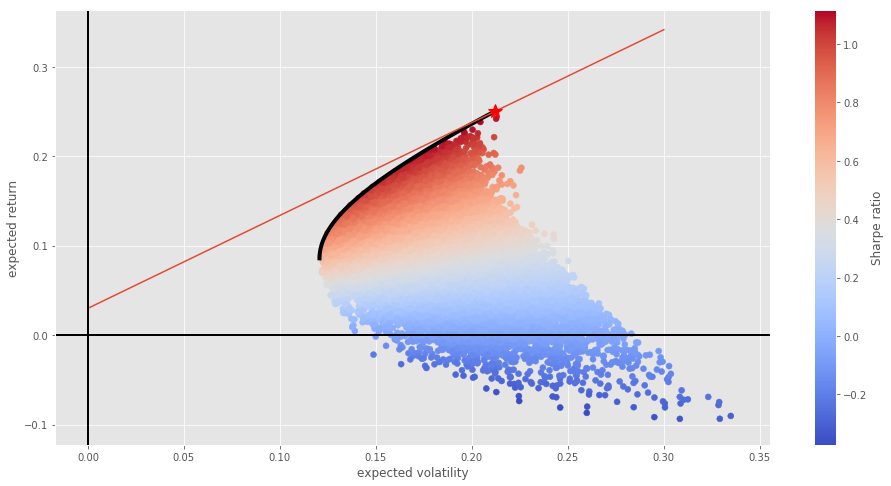

In [50]:
plt.figure(figsize=(16, 8))
plt.scatter(pvols, prets,
 c=(prets - 0.01) / pvols, marker='o', cmap='coolwarm')
 # random portfolio composition
plt.plot(evols, erets, 'black', lw=4.0)
 # efficient frontier
cx = np.linspace(0.0, 0.3)
plt.plot(cx, opt[0] + opt[1] * cx, lw=1.5)
 # capital market line
plt.plot(opt[2], f(opt[2]), 'r*', markersize=15.0)
plt.grid(True)
plt.axhline(0, color='k', ls='-', lw=2.0)
plt.axvline(0, color='k', ls='-', lw=2.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

### The optimal portfolio allocation

In [ ]:
res['x'].round(3)